In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
sys.path.append("../")
import matplotlib.pyplot as plt
import time

In [2]:
import preprocess_blockSVD as pre_svd
import trefide as tfd
import spatial_filtering as sp_filters
#from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
#import scipy as sp
import tools as tools
import cvxpy as cp
import caiman as cm


/home/ekellbuch/miniconda2/envs/volcaim/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import h5py

project_dir = '/data/lab/Dropbox/QState_IntrinsicExcitability/'
fname = 'IntrinsicExcitability_movie017.mat'
#data = sio.loadmat(project_dir+fname)
with h5py.File(os.path.join(project_dir, fname)) as f:
    m_orig = f['mov']['data'].value.T
    sampleRate = f['mov']['sampleRate'].value
    sampleRate_units = f['mov']['sampleRate_units'].value
    print(list(f['mov'].keys()))

['data', 'disclaimer', 'drug', 'fileNameHash', 'group', 'pixelSize', 'pixelSize_units', 'sampleRate', 'sampleRate_units', 'stimulation', 'timeDim']


(80, 800, 7082)
(900, 70, 70)


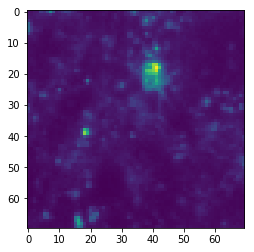

In [4]:
print(m_orig.shape)
m_orig_ = m_orig[5:-5,150:220,2100:3000].transpose([2,0,1])
print(m_orig_.shape)
plt.imshow(m_orig_[0,:,:])

In [5]:
def remove_trend(Y_rm,detrend_option='linear'):
    mean_pixel = Y_rm.mean(axis=1,keepdims=True)
    Y_rm2 = Y_rm - mean_pixel
    # Detrend linear 
    if detrend_option=='linear':
        detr_data = sp.signal.detrend(Y_rm2[:,:],axis=1,type='l')
    elif detrend_option=='quad':
        detr_data = detrend(Y_rm)
    Y_det = detr_data + mean_pixel
    offset = Y_rm - Y_det
    return Y_det, offset

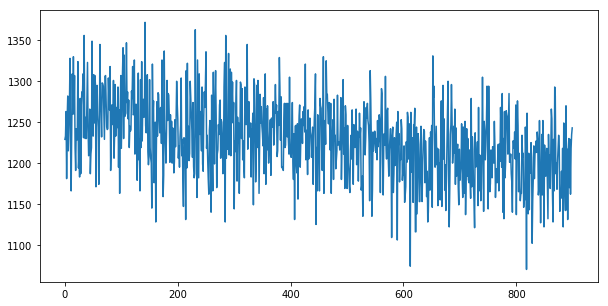

In [6]:
fig = plt.figure(figsize=(10,5))
plt.plot(m_orig_[:,0,0])

In [ ]:
Frame = cm.movie(m_orig_)#[100:5100,1:-5,28:]
Frame.play(gain=5, fr=10, magnification=5)

In [7]:
images_ = m_orig_.transpose([1,2,0])
dims = images_.shape
print(dims)

(70, 70, 900)


In [8]:
# Caserati representation d x T
images_r = images_.reshape((np.prod(dims[:2]),dims[2]),order='F')

# if temporal downsampling
if False:
    ts = 5
    images_r = pre_svd.temporal_decimation(images_r.T,ts).T
    dims = dims[0], dims[1], dims[2]//ts
# get rid of trend
if True:
    images_detr, offset = tools.remove_trend(images_r)
    images_r = images_detr.copy()
else:
    offset = np.zeros(images_r.shape)

In [9]:
#(0) 
if True:
    # run WF on Y
    images_wf,_ = sp_filters.spatial_filter_image(images_r.reshape(dims,order='F'))
    # cm.movie(images_wf).transpose([2,0,1]).play(magnification=10)
    images_wf = images_wf.reshape((np.prod(dims[:2]),dims[2]),order='F')
else:
    images_wf = images_r.copy()

first k pixels 0
first k pixels 1000
first k pixels 2000
first k pixels 3000
first k pixels 4000


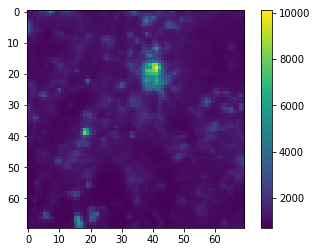

In [10]:
plt.imshow(images_wf.reshape(dims,order='F')[:,:,0])
plt.colorbar()

In [11]:
# subtract off the mean,
mean_px = images_wf.mean(1,keepdims=True)
images_wf = images_wf - mean_px
if True:
    # compute noise level
    # and normalize each pixel to have unit noise level
    noise_level = sp_filters.noise_estimator(images_wf[:,:],range_ff=[0.25,0.5])
    image_= images_wf/noise_level[:,np.newaxis]
    # confirm noise variance =1 in each pixel
    tmp_ = sp_filters.noise_estimator(image_[:,:],range_ff=[0.25,0.5])
    print(tmp_.min())
    print(tmp_.max())
else:
    image_ = images_wf

0.9999999999999984
1.0000000000000013


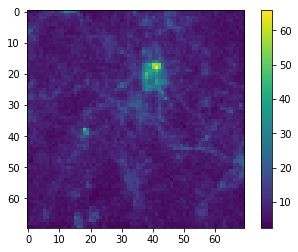

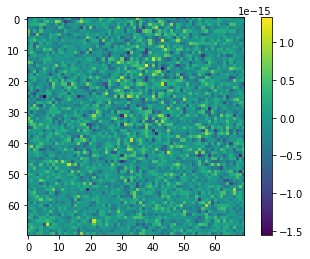

In [12]:
plt.imshow(noise_level.reshape(dims[:2],order='F'))
plt.colorbar()
plt.show()
plt.imshow(tmp_.reshape(dims[:2],order='F')-1)
plt.colorbar()

In [13]:
if False:
    U,s,Vt = pre_svd.compute_svd(image_,method='randomized',n_components=2)
    movie_rank2 = U.dot(np.diag(s).dot(Vt))
    residual = image_ - movie_rank2
    W = residual.reshape(dims,order='F')
else:
    W = image_.reshape(dims,order='F')

In [20]:
k = 25

Patch 0
	Patch 0 run for 0
Patch 1
	Patch 1 run for 0
Patch 2
	Patch 2 run for 0
Patch 3
	Patch 3 run for 0
Patch 4
	Patch 4 run for 0
Patch 5
	Patch 5 run for 0
Patch 6
	Patch 6 run for 0
Patch 7
	Patch 7 run for 0
Patch 8
	Patch 8 run for 0
Patch 9
	Patch 9 run for 0
Patch 10
	Patch 10 run for 0
Patch 11
	Patch 11 run for 0
Patch 12
	Patch 12 run for 0
Patch 13
	Patch 13 run for 0
Patch 14
	Patch 14 run for 0
Patch 15
	Patch 15 run for 0
Patch 16
	Patch 16 run for 0
Patch 17
	Patch 17 run for 0
Patch 18
	Patch 18 run for 0
Patch 19
	Patch 19 run for 0
Patch 20
	Patch 20 run for 0
Patch 21
	Patch 21 run for 0
Patch 22
	Patch 22 run for 0
Patch 23
	Patch 23 run for 0
Patch 24
	Patch 24 run for 0


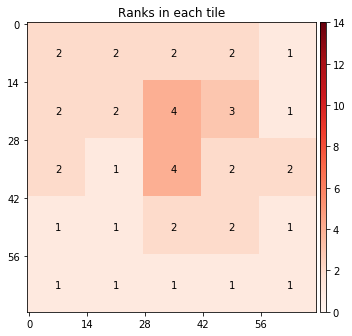

M rank 44


In [21]:
maxlag = 5#5
confidence = 0.95
min_rank = 1
Yd1,_ = pre_svd.svd_patch(W,k=k,maxlag=maxlag,confidence=confidence,
                                greedy=False,fudge_factor=1,
                                 mean_th_factor=2.,min_rank=min_rank)

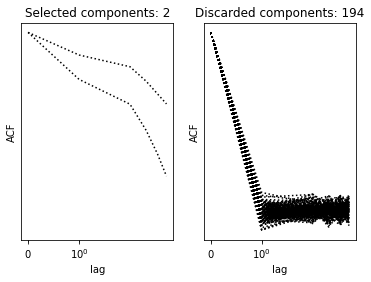

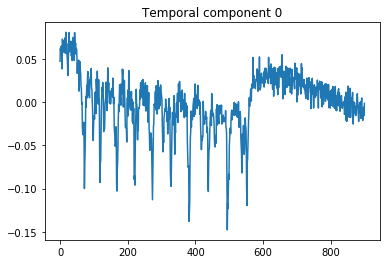

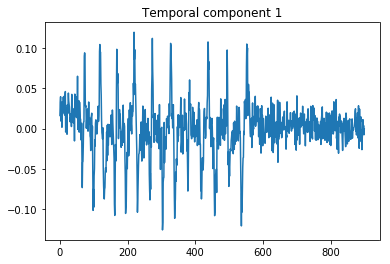

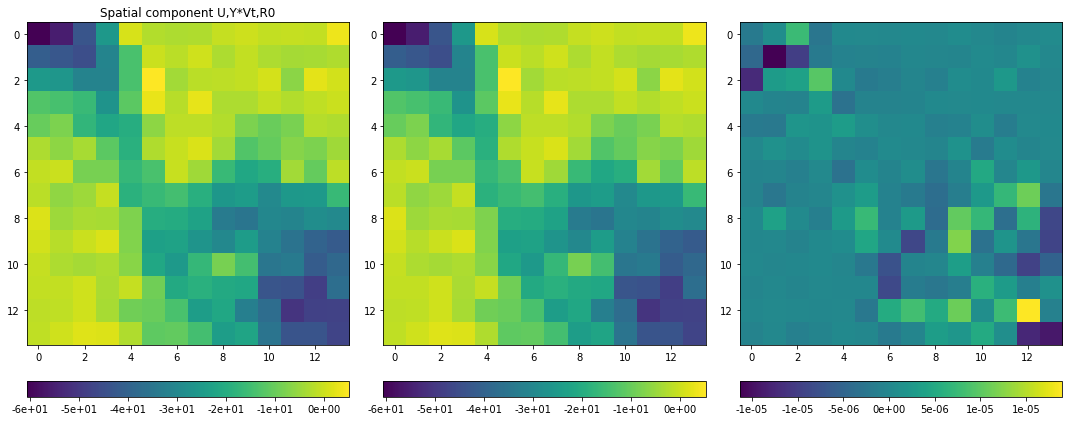

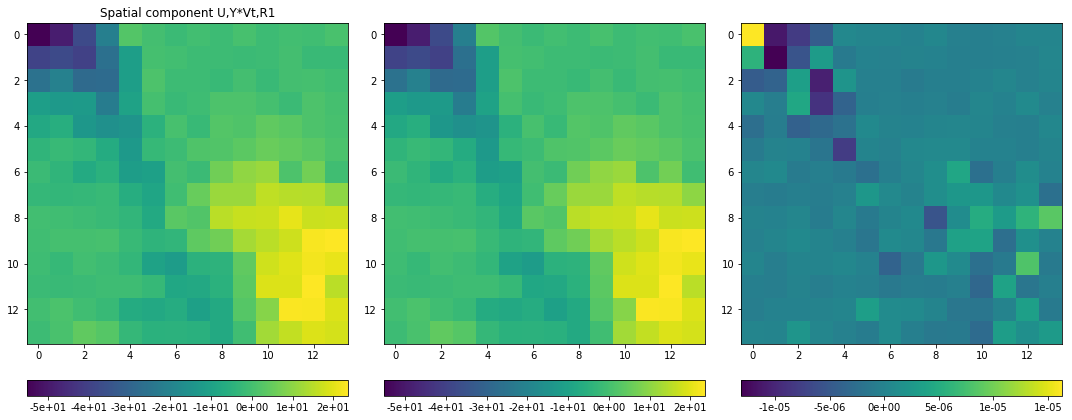

*Running Part (1) iter 0 with 2 components
solve V(i) = argmin_W ||D^2 W||_1 
	 st ||V_i-W||_2<fudge_factor*sigma_i*sqrt(T)


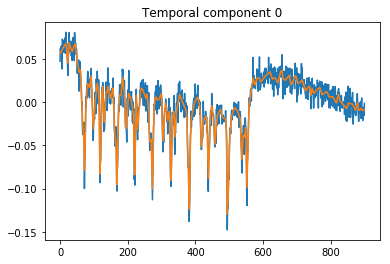

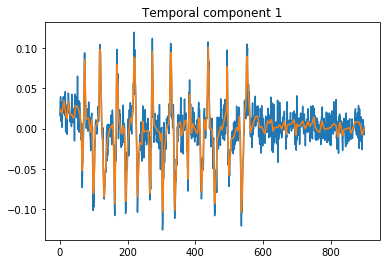

solve U(j) = argmin_W ||W||_1 st ||Y_j-W'V_TF(j)||_2^2<T*fudge^2


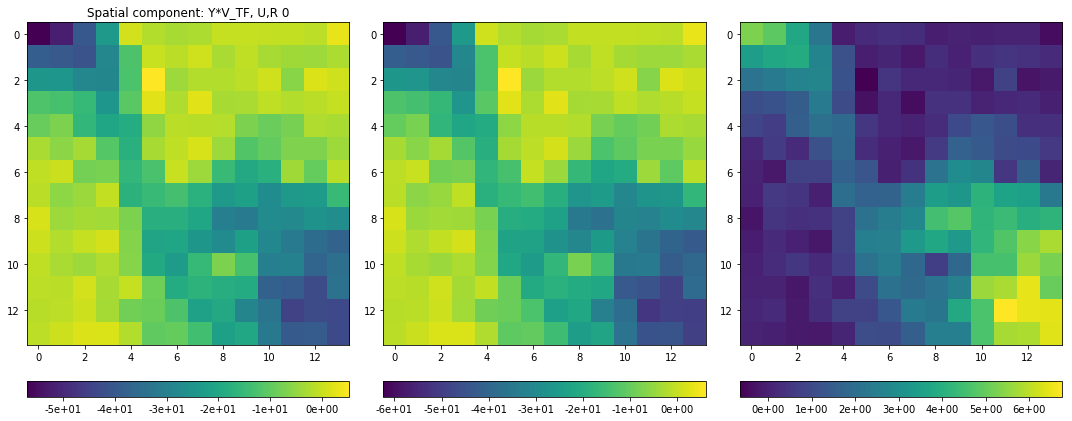

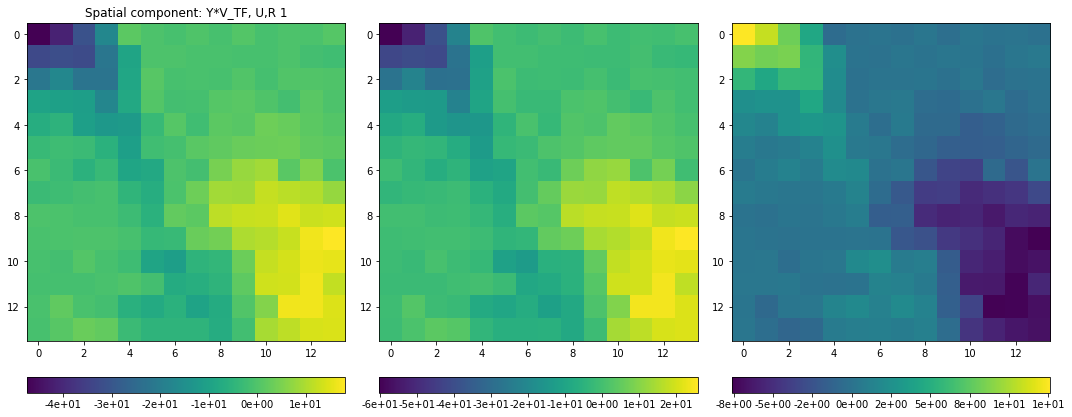

Iterate until F(U,V) stops decreasing significantly
For now fixed iterations as 5
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


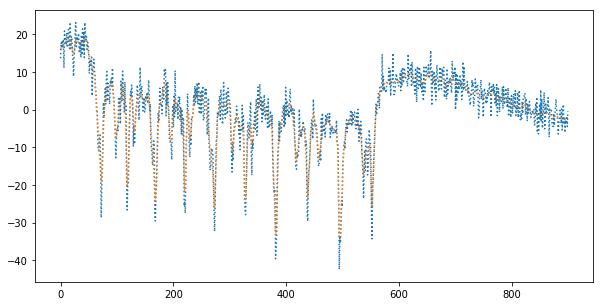

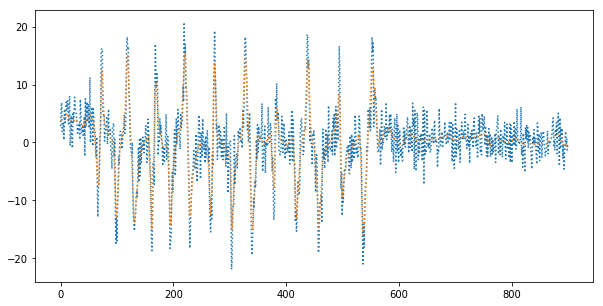

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


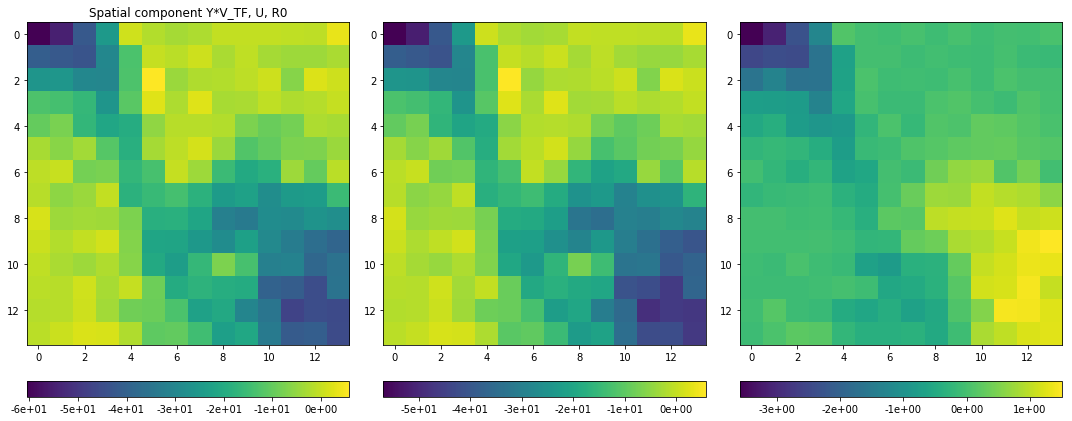

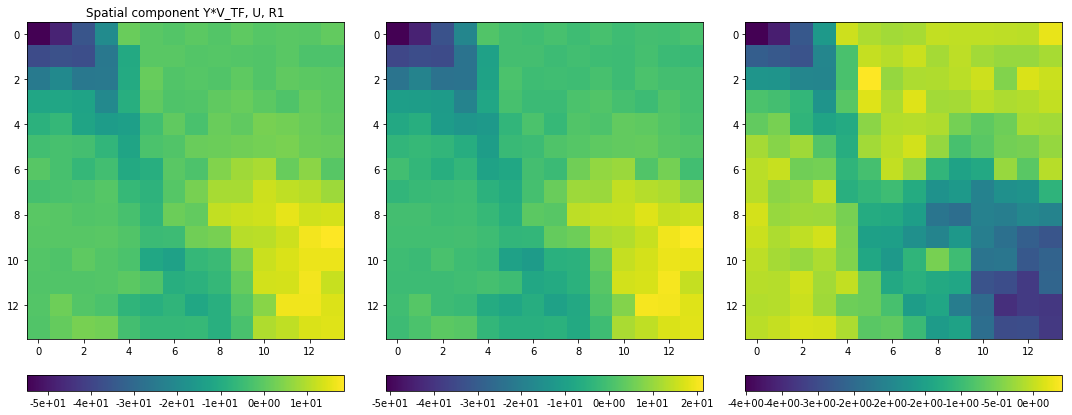

	Iter 0 errors (9025+41+0)=9066
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


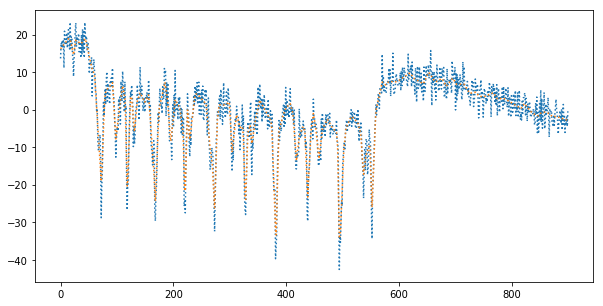

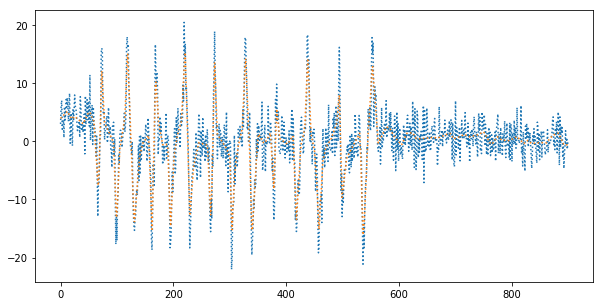

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


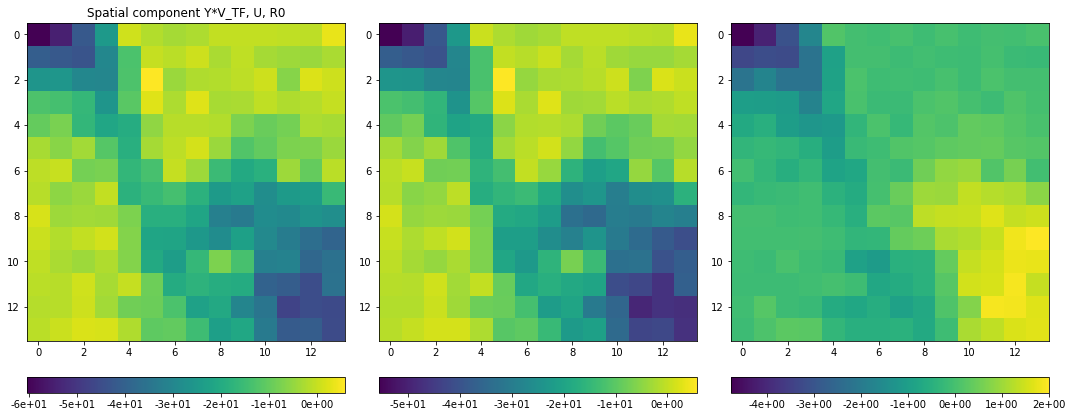

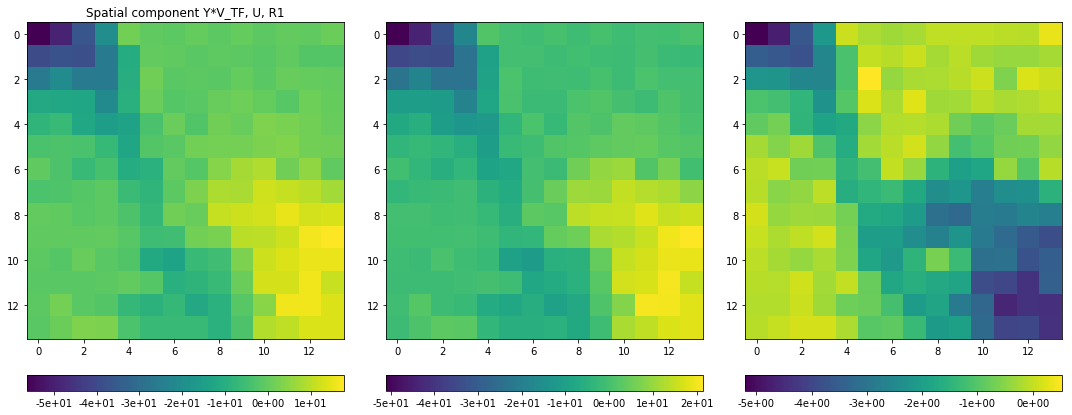

	Iter 1 errors (8994+41+0)=9035
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


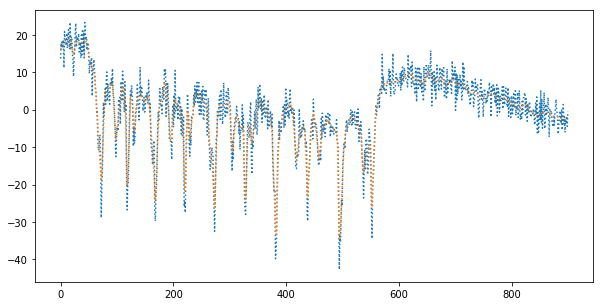

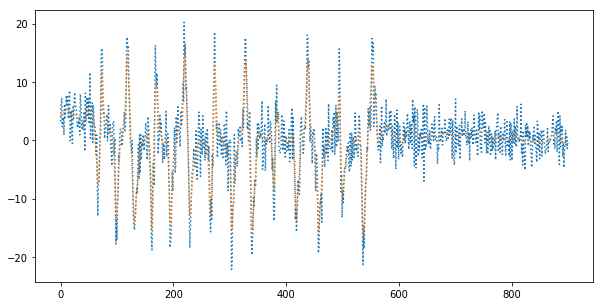

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


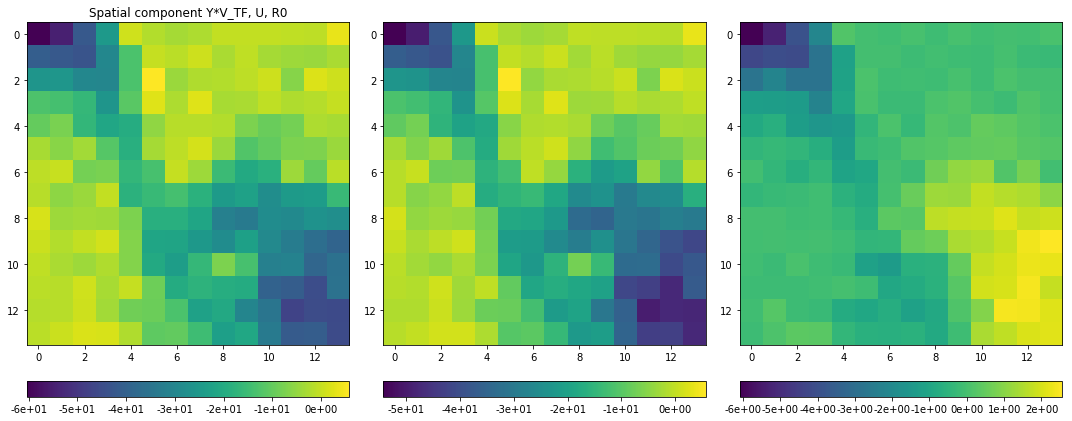

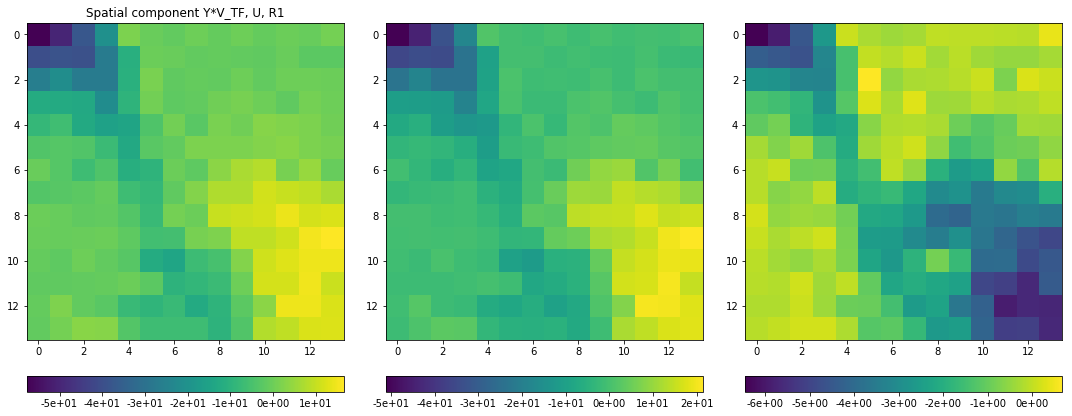

	Iter 2 errors (8968+41+0)=9009
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


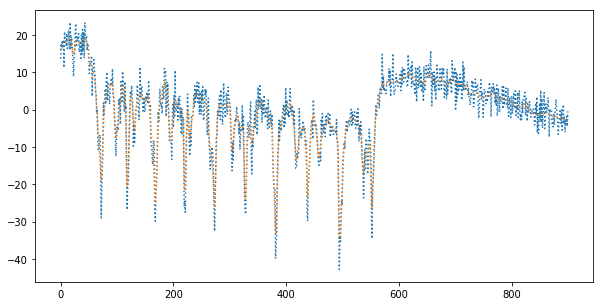

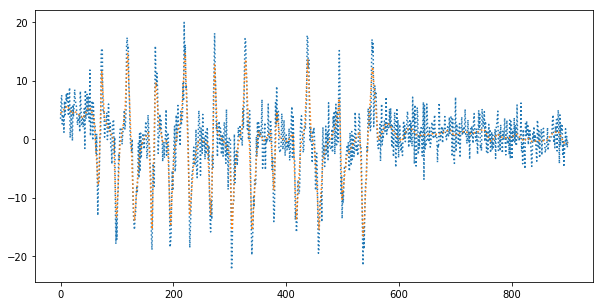

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


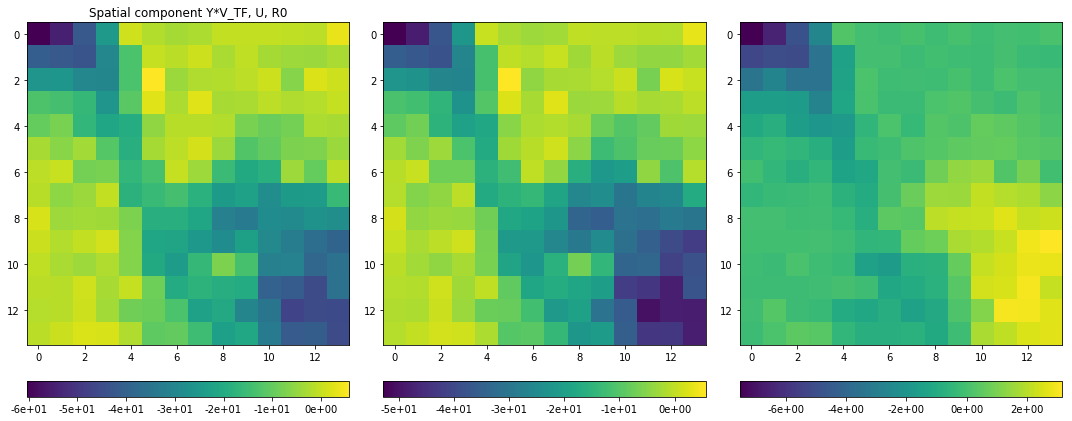

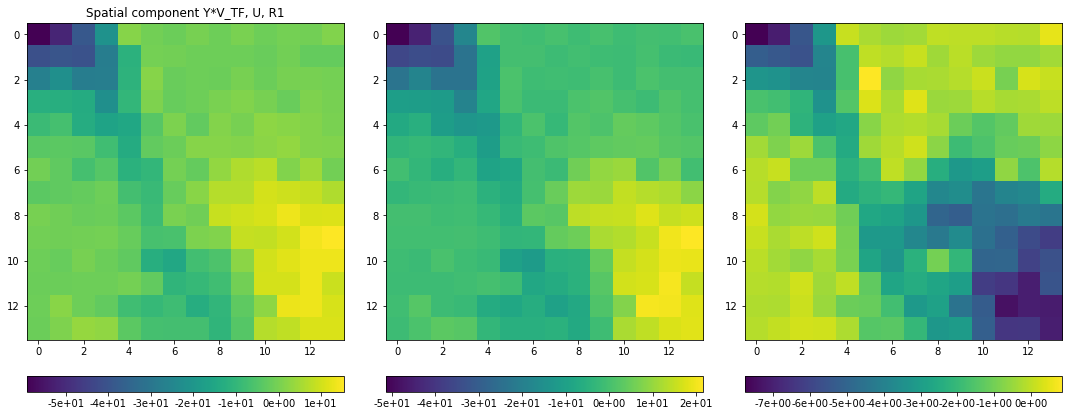

	Iter 3 errors (8940+40+0)=8980
*Running Part (1) of iter 0 with 2 components
	update V_i : min ||Y-UV||^2_2 + sum_i lambda_i ||D^2 V_i||_1


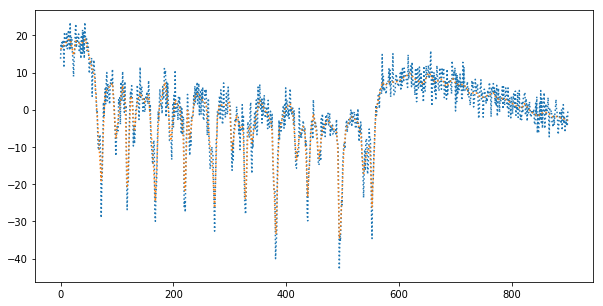

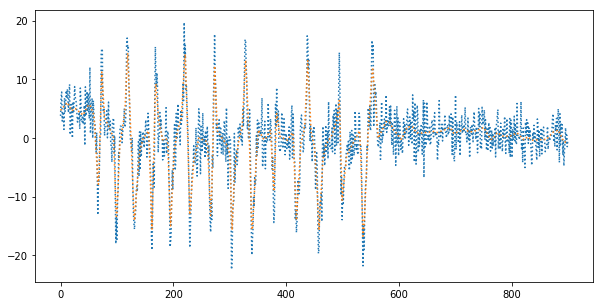

	update U_j: min ||Y-UV||^2_2 + sum_j nu_j ||U_j||_1


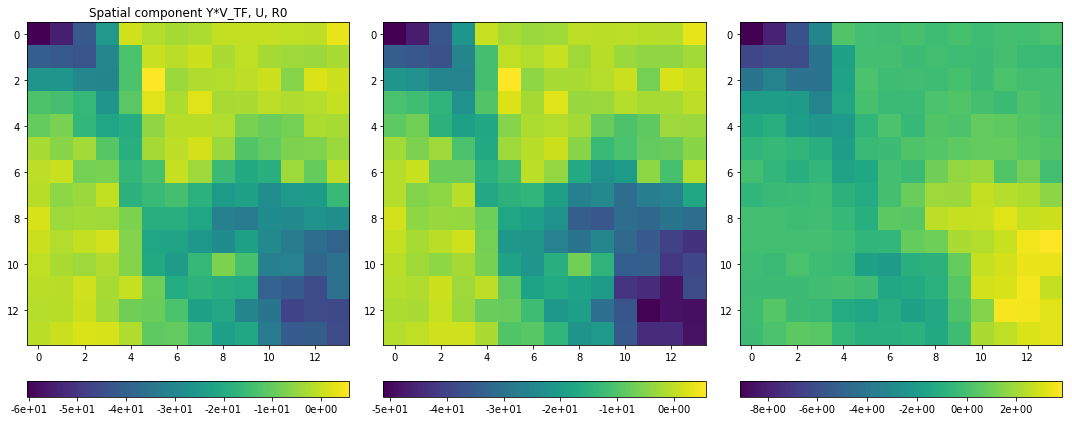

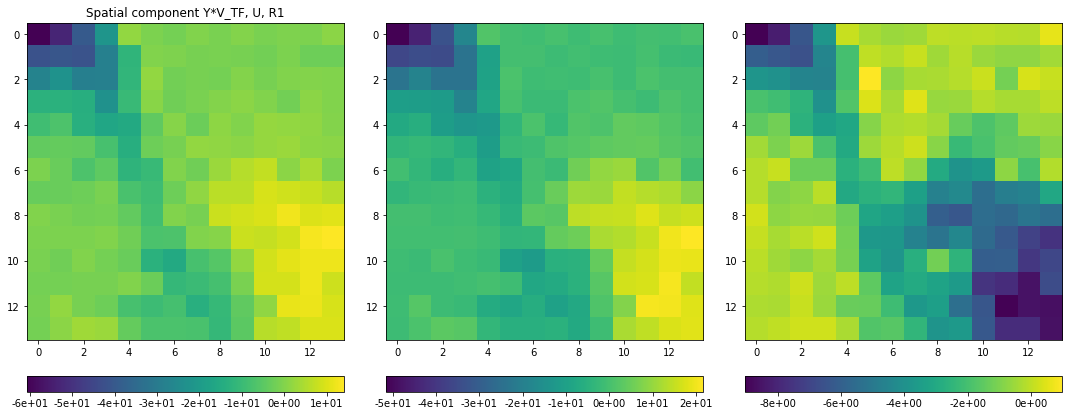

	Iter 4 errors (8910+40+0)=8950


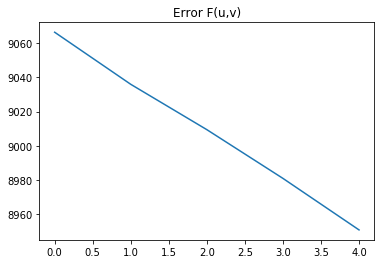

*Running Part (2) of iter 0 with 2 components


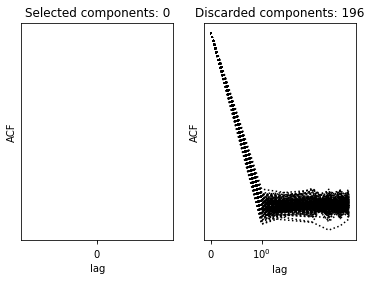

Final number of components 2
Running final update


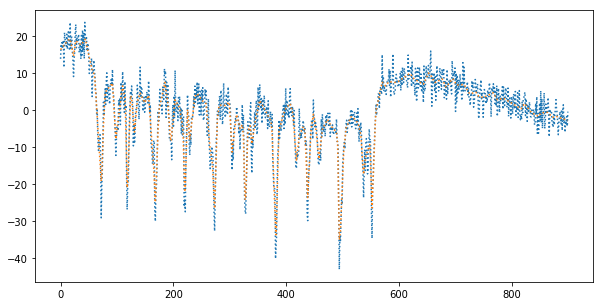

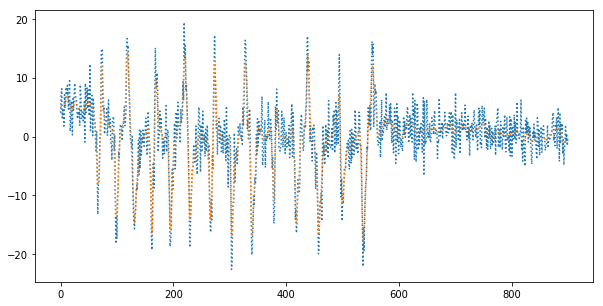

U(j) = argmin_W ||W||_1 st ||Y_j-W'V_TF(j)||_2^2<T
ERROR: Greedy solving failed, using default parameters
Run for 241


In [23]:
# greedy for a single tile (~ neuron size)
patches = pre_svd.split_image_into_blocks(W,k)
start= time.time()
b,_ = pre_svd.compress_dblocks(patches[1],
                                maxlag=maxlag,confidence=confidence,
                                greedy=True,fudge_factor=0.9,
                                mean_th_factor=2,U_update=True,
                              verbose=True,plot_en=True,min_rank=1)
print('Run for %.f'%(time.time()-start))


In [ ]:
Yd,_ = pre_svd.svd_patch(W,k=k,maxlag=maxlag,confidence=confidence,
                         greedy=True,fudge_factor=0.9,mean_th_factor=2,min_rank=1,
                         U_update=True,plot_en=False)

In [ ]:
def redo_(W_,dims,noise_level,mean_px):
    W = W_.reshape((np.prod(dims[:2]),dims[2]),order='F').copy()
    W= W*noise_level[:,np.newaxis]
    W+= mean_px
    W = W.reshape(dims,order='F')
    return W

In [ ]:
images_rd_= images_r.reshape(dims,order='F')
Yd1_ = redo_(Yd1,dims,noise_level,mean_px) #vanilla
Yd_ = redo_(Yd,dims,noise_level,mean_px) #greedy

In [ ]:
M1 = cm.movie(np.asarray(images_rd_).transpose([2,0,1]))
M2 = cm.movie(np.asarray(Yd1_).transpose([2,0,1]))
M3 = cm.movie(np.asarray(Yd_).transpose([2,0,1]))

M4  = M1 - M2
M5  = M1 - M3

MZ = np.zeros(M1.shape)
if False:
    M1 = M1-M1.min(0,keepdims=True)
    M2 = M2-M2.min(0,keepdims=True)
    M3 = M3-M3.min(0,keepdims=True)
    M4 = M4-M4.min(0,keepdims=True)
    M5 = M5-M5.min(0,keepdims=True)

cm.concatenate([
    cm.concatenate([M1,M2,M3],axis=2),
    cm.concatenate([MZ,M4,M5],axis=2)
    ],axis=1).play(gain=1,magnification=4)